In [1]:
from util import *
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, PolynomialFeatures
import matplotlib.pyplot as plt
import pytz
import xgboost as xgb
plt.style.use('ggplot')

For Beijing:
* Air Quality data: https://biendata.com/competition/airquality/bj/2018-04-01-0/2018-04-01-23/2k0d1d8
* Observed Meteorology: https://biendata.com/competition/meteorology/bj/2018-04-01-0/2018-04-01-23/2k0d1d8
* Meteorology Grid Data: https://biendata.com/competition/meteorology/bj_grid/2018-04-01-0/2018-04-01-23/2k0d1d8

For London:
* Air Quality data: https://biendata.com/competition/airquality/ld/2018-05-01-0/2018-05-01-23/2k0d1d8
* Meteorology Grid Data: https://biendata.com/competition/meteorology/ld_grid/2018-05-01-0/2018-05-01-23/2k0d1d8
* 48-future http://kdd.caiyunapp.com/competition/forecast/bj/2018-05-01-0/2k0d1d8
* `curl https://biendata.com/competition/meteorology/ld_grid/ld/2018-03-30-0/2018-04-28-23/2k0d1d8 >> ld_meo_new.csv` 
* `wget https://biendata.com/competition/meteorology/bj_grid/2018-03-30-0/2018-05-01-23/2k0d1d8 -O bj_meo_new.csv`
* `wget https://biendata.com/competition/meteorology/ld_grid/2018-03-30-0/2018-05-01-23/2k0d1d8 -O ld_meo_new.csv`

In [2]:
print("Data loading...")
city = 'bj'
df_aq = pd.read_csv("../input/" + city + "_aq_imputed.csv")
df_aq.utc_time = pd.to_datetime(df_aq.utc_time)
df_meo = get_meo(city)
# Imputate with meo_stats
df_meo_table = get_meo_stats(df_meo)
df_station = pd.read_csv("../input/" + city +"_aq_stations.csv")

Data loading...


## Feature Engineering

In [3]:
df_sample = get_submission_init(df_station, city)
df_ = pd.concat([df_aq, df_sample])

# Join station
df_ = pd.merge(df_, df_station, 'left', left_on='stationId', right_on='Station_ID')

# Join meo
df_.longitude = df_.longitude.round(1)
df_.latitude = df_.latitude.round(1)
df_ = pd.merge(df_, df_meo, 'left', 
              left_on=['utc_time', 'longitude', 'latitude'], 
              right_on=['utc_time', 'longitude', 'latitude']
             )

df_['month'] = df_.utc_time.dt.month
df_['day'] = df_.utc_time.dt.day
df_['hour'] = df_.utc_time.dt.hour
df_['weekday'] = df_.utc_time.dt.weekday
df_['weekofyear'] = df_.utc_time.dt.weekofyear

df_meo_table = df_meo_table.reset_index()
df_fe = pd.merge(df_, df_meo_table, how='left', suffixes=("", "_pred"),
                     left_on =['latitude', 'longitude', 'weekofyear', 'hour'], 
                     right_on=['latitude', 'longitude', 'weekofyear', 'hour'])

for target in [ 'temperature', 'pressure', 'humidity', 'wind_direction', 'wind_speed/kph']:
    df_fe.loc[df_fe[target].isnull(), target] = df_fe[target + '_pred']

df_fe['wind_direction'] = pd.cut(df_fe['wind_direction'], bins=8, labels=False)

# le_station_type = LabelEncoder()
# le_station_type.fit(df.station_type)
# df.station_type = le_wind_direction.transform(df.station_type)

# le_stationId = LabelEncoder()
# le_stationId.fit(df.stationId)
# df.stationId = le_stationId.transform(df.stationId)
df = pd.get_dummies(df_fe, columns=['month', 'day', 'hour', 'weekday', 'stationId', 'station_type', 'wind_direction'])


In [6]:
X_cols_exclude = [ 'PM2.5', 'PM10', 'O3', 'Station_ID', 'SiteName', 'api_data', 'need_prediction', 'historical_data', 
                  'utc_time', 'pressure_pred', 'temperature_pred', 'wind_direction_pred', 'wind_speed/kph_pred', 
                  'humidity_pred', 'index', 'longitude', 'latitude', 'stationName', 'weekofyear']
X_cols = [col for col in df.columns if col not in X_cols_exclude]

valid_time = (pd.datetime.now(pytz.utc)-pd.DateOffset(2)).strftime('%Y-%m-%d 00:00:00')
test_time = pd.datetime.now(pytz.utc).strftime('%Y-%m-%d 00:00:00')

if city=='ld':
    df = df.drop(df[df.need_prediction.isnull() & (df['PM2.5'].isnull() | df['PM10'].isnull())].index)
df_train = df[df.utc_time < valid_time]
df_valid = df[(df.utc_time >= valid_time) & (df.utc_time < test_time)]
df_test = df[df.utc_time >= test_time]
if city=='ld':
    df_test = df_test[df_test.need_prediction==1]

X_train = df_train[X_cols]
X_valid = df_valid[X_cols]
X_test = df_test[X_cols]

[0]	train-rmse:86.7809	valid-rmse:79.5534	train-SMAPE:1.56986	valid-SMAPE:1.62905
Multiple eval metrics have been passed: 'valid-SMAPE' will be used for early stopping.

Will train until valid-SMAPE hasn't improved in 20 rounds.
[1]	train-rmse:84.0481	valid-rmse:77.2337	train-SMAPE:1.35232	valid-SMAPE:1.39926
[2]	train-rmse:81.3656	valid-rmse:75.4174	train-SMAPE:1.19921	valid-SMAPE:1.23809
[3]	train-rmse:78.5377	valid-rmse:72.7746	train-SMAPE:1.08346	valid-SMAPE:1.02234
[4]	train-rmse:75.9692	valid-rmse:70.831	train-SMAPE:0.992118	valid-SMAPE:0.892842
[5]	train-rmse:73.6043	valid-rmse:68.6539	train-SMAPE:0.918422	valid-SMAPE:0.765592
[6]	train-rmse:71.3043	valid-rmse:66.6471	train-SMAPE:0.860034	valid-SMAPE:0.682553
[7]	train-rmse:69.105	valid-rmse:65.3897	train-SMAPE:0.811661	valid-SMAPE:0.646882
[8]	train-rmse:67.173	valid-rmse:63.6776	train-SMAPE:0.770143	valid-SMAPE:0.624151
[9]	train-rmse:65.3355	valid-rmse:62.2977	train-SMAPE:0.735535	valid-SMAPE:0.623244
[10]	train-rmse:63.5326	

[22]	train-rmse:43.0382	valid-rmse:56.5675	train-SMAPE:0.692474	valid-SMAPE:0.553184
[23]	train-rmse:42.2039	valid-rmse:56.394	train-SMAPE:0.684721	valid-SMAPE:0.549059
[24]	train-rmse:41.4643	valid-rmse:56.028	train-SMAPE:0.676507	valid-SMAPE:0.541479
[25]	train-rmse:40.731	valid-rmse:55.6945	train-SMAPE:0.669913	valid-SMAPE:0.536523
[26]	train-rmse:40.0425	valid-rmse:55.5027	train-SMAPE:0.663943	valid-SMAPE:0.531877
[27]	train-rmse:39.4791	valid-rmse:55.4088	train-SMAPE:0.65809	valid-SMAPE:0.528866
[28]	train-rmse:38.8482	valid-rmse:55.3041	train-SMAPE:0.653033	valid-SMAPE:0.526045
[29]	train-rmse:38.1801	valid-rmse:55.0439	train-SMAPE:0.646842	valid-SMAPE:0.520697
[30]	train-rmse:37.559	valid-rmse:54.5362	train-SMAPE:0.642194	valid-SMAPE:0.515061
[31]	train-rmse:37.0179	valid-rmse:54.7861	train-SMAPE:0.6384	valid-SMAPE:0.514874
[32]	train-rmse:36.5524	valid-rmse:54.8225	train-SMAPE:0.634184	valid-SMAPE:0.514099
[33]	train-rmse:36.1205	valid-rmse:54.9343	train-SMAPE:0.630387	valid-SM

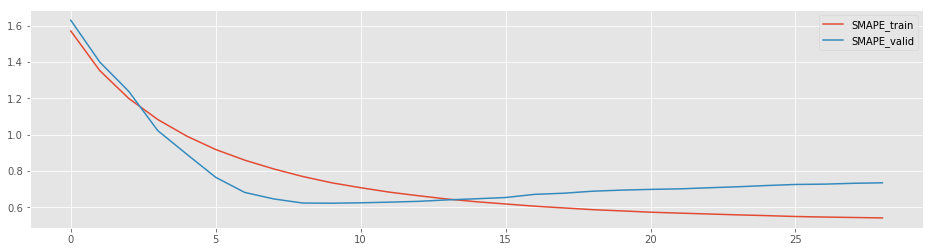

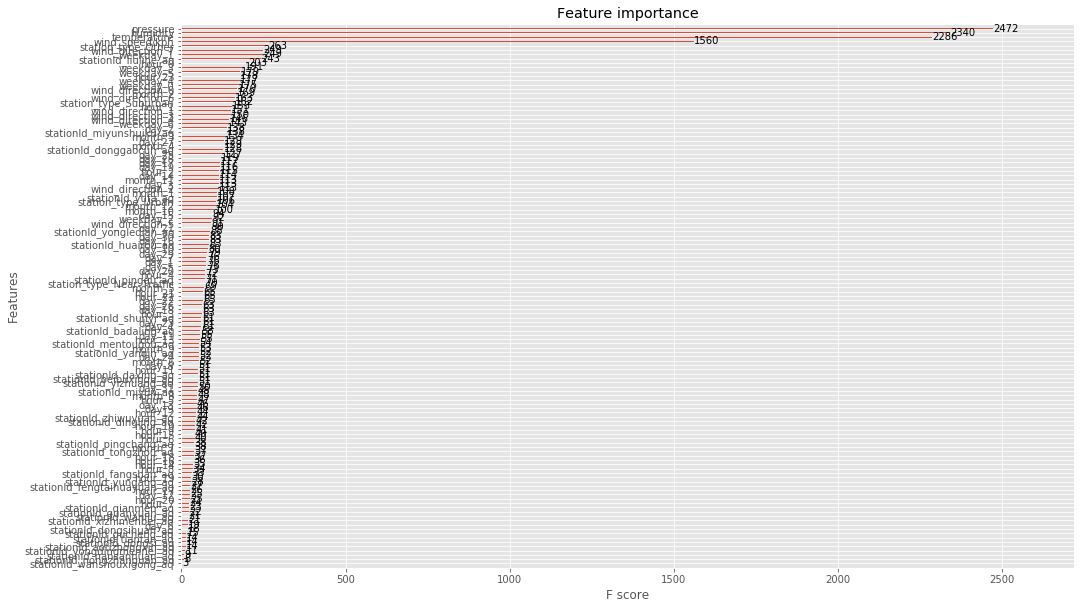

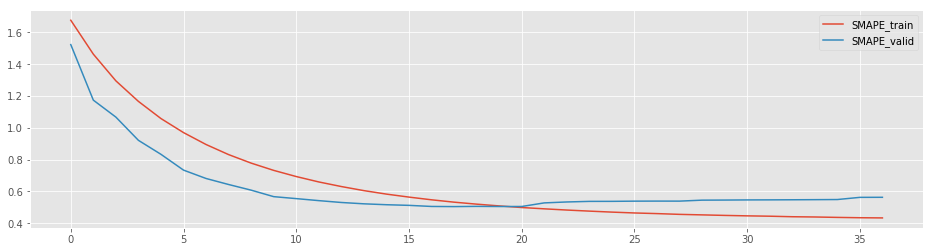

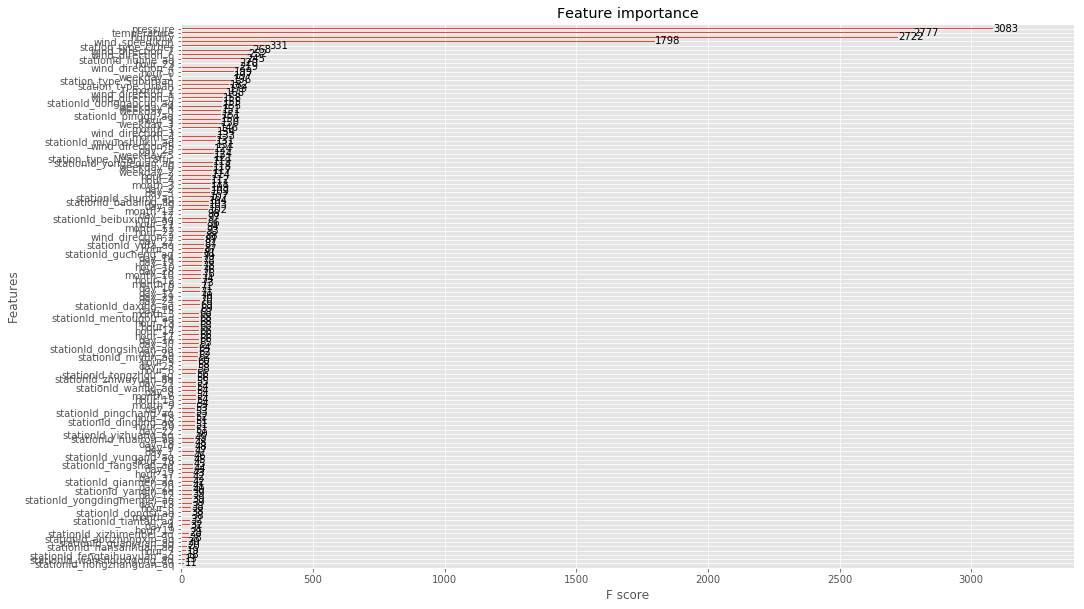

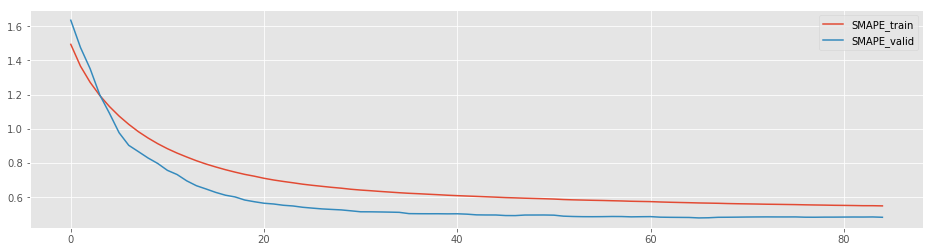

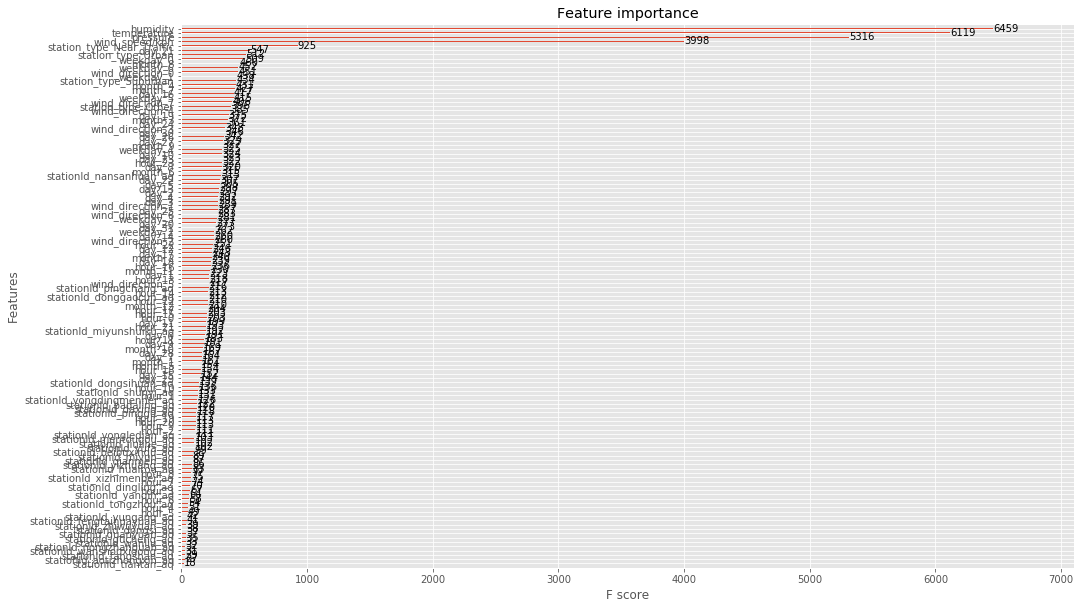

In [28]:
# %%time
y_cols = ['PM2.5', 'PM10', 'O3'] if city=='bj' else ['PM2.5', 'PM10']

bsts = []
gpu_reses = []
for y_col in y_cols:
    y_train = df_train[y_col]
    y_valid = df_valid[y_col]
    y_test = df_test[y_col]
    
    dtrain = xgb.DMatrix(X_train, y_train)
    dvalid = xgb.DMatrix(X_valid, y_valid, nthread=-1)
    dtest = xgb.DMatrix(X_test, nthread=-1)

    param = {
        'max_depth': 10,
        'learning_rate': 0.05,
        'n_estimators': 5000,
        'colsample_bytree': 0.7,
        'subsample': 0.9,
        'min_child_weight': 2, 
        'reg_alpha': 0.001, 
        'objective':'gpu:reg:linear',
        'tree_method': 'gpu_hist',
        'random_state': 0,
    }

    watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
    gpu_res = {}
    bst = xgb.train(param, dtrain, num_boost_round=300, evals=watchlist , feval=SMAPE, 
                    early_stopping_rounds=20, evals_result=gpu_res)
    
    bsts.append(bst)
    gpu_reses.append(gpu_res)
    
    df_metric = pd.concat([pd.DataFrame(gpu_res['train']['SMAPE']), pd.DataFrame(gpu_res['valid']['SMAPE'])], axis=1)
    df_metric.columns = ['SMAPE_train', 'SMAPE_valid']
    df_metric.plot(figsize=(16, 4))

    fig, ax = plt.subplots(figsize=(16, 10))
    xgb.plot_importance(bst, ax=ax)


In [19]:
for i, y_col in enumerate(y_cols):
#     y_pred = bsts[i].predict(dtest)
    y_pred = bsts[i].predict(dtest, ntree_limit=bst.best_iteration)
    df_test[y_col] = y_pred

In [20]:
df_test = df_test[['Station_ID', 'utc_time'] + y_cols]
df_result = df_test.groupby(['Station_ID', 'utc_time']).mean().reset_index()

In [21]:
start_time = pd.datetime.now(pytz.utc).strftime('%Y-%m-%d 00:00:00')
end_time = (pd.datetime.now(pytz.utc)-pd.DateOffset(-1)).strftime('%Y-%m-%d 23:00:00')
utc_time = pd.date_range(start=start_time, end=end_time, freq="1H")
time_to_idx = {time:str(i) for i, time in enumerate(utc_time)}
df_result['test_id'] = df_result.Station_ID + "#" + df_result.utc_time.apply(lambda time: time_to_idx[time])
if city=='ld':
    df_result['O3'] = 0
df_result = df_result[['test_id', 'PM2.5', 'PM10', 'O3']]
df_result.to_csv("../input/" + city + ".csv", index=False)

In [22]:
df_result.describe()

,PM2.5,PM10,O3
count,1680.000000,1680.000000,1680.000000
mean,56.946541,124.832314,91.001671
std,7.011242,27.536228,24.629553
min,39.332191,86.436501,42.217564
25%,52.957999,101.711693,74.341660
50%,56.888905,116.054108,93.912659
75%,63.289299,151.164398,110.585979
max,69.193573,200.357590,149.446014


## Submission

In [27]:
# files={'files': open('../input/iar_0501.csv','rb')}

# data = {
#     "user_id": "tnlin",   #user_id is your username which can be found on the top-right corner on our website when you logged in.
#     "team_token": "157911850c1d57e0ac45ef110ed2f3a823e1e962300f6f1e8e1abe7c254431dc", #your team_token.
#     "description": 'Baseline model',  #no more than 40 chars.
#     "filename": "iar_0501.csv", #your filename
# }

# url = 'https://biendata.com/competition/kdd_2018_submit/'
# response = requests.post(url, files=files, data=data)
# print(response.text)

{"success": true}
